# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot  as plt
import os
import random
from tqdm import trange, tqdm
import linecache
import shutil
import numpy as np
import math
import cv2

## Config

In [3]:
cfg_num = 10000 # samples P or N
cfg_counts = 5 # samples from single line
cfg_length = 320 # length of sample

# Utils
read data from txt

In [4]:
def mask2line(img):
    height, width, _ = img.shape
    line = []
    for w in range(width):
        for h in range(height):
            if (img[h,w] == np.array([0, 0, 255])).all():
                line.append(h)
                break
    return line

In [8]:
def read_data(path):
    f = open(path)
    skylines = []
    lines = f.readlines()
    for i, line in enumerate(lines[:30]):
        print(i)
        skyline = list(map(int, map(float, line.strip().split(',')[:-1])))
        points = [(skyline[i], skyline[i+1]) for i in range(0, len(skyline)-1, 2)]
        
        img = np.zeros((480, 640, 3), np.uint8)
        for i, point in enumerate(points):
            if i == len(points) -1:
                break
            cv2.line(img, points[i], points[i+1], (0,0,255), 1)
        
        skyline = mask2line(img)
        
        skylines.append(skyline)
    
    f.close()
    return skylines



In [9]:
def read_data_row(path, num):       
    return linecache.getline(path,num)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


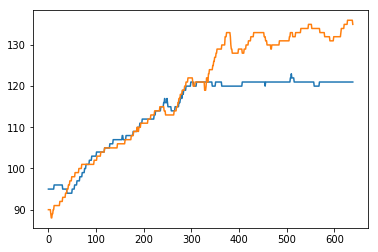

In [10]:
path_d = "../data/data_geo3k/dem.txt"
path_r = "../data/data_geo3k/real.txt"
skylines_d = read_data(path_d)
skylines_r = read_data(path_r)
print(len(skylines_d))


(0, 480)

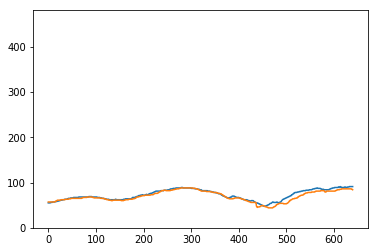

In [13]:
plt.plot(skylines_d[0])
plt.plot(skylines_r[0])
plt.ylim(0,480)

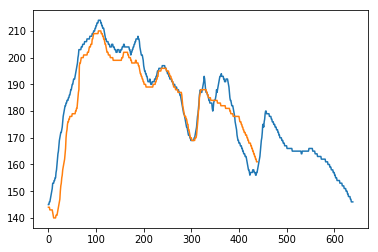

In [12]:
plt.plot(skylines_d[1752])
plt.plot(skylines_r[1752])

# datasets prepare

   构建训练样本和测试样本

In [16]:
def datasets_prepare(lines_d, lines_r, train=True):
    if train:
        if "train" in os.listdir("../data/"):
            shutil.rmtree('../data/train')  
        os.mkdir("../data/train")
        
        if "train_val" in os.listdir("../data/"):
            shutil.rmtree("../data/train_val")
        os.mkdir("../data/train_val")
        
       
        # train P samples
        for i in trange(cfg_num):
            index = random.randint(0, len(lines_d)-1)
            for j in range(cfg_counts):
                left = random.randint(0, min(len(lines_d[index]), len(lines_r[index]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '1'
                
                #  get train-positive samples
                with open("../data/train/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
               # get train_val for calculate top-N
                if j == 0 and i < 1000:
                    with open("../data/train_val/{}.{}".format(i, j), 'w') as f_a:
                        f_a.write(str_tmp)
                    
        # train N samples       
        for i in trange(cfg_num, 2*cfg_num):
            index_d = random.randint(0, len(lines_d)-1)
            index_r = random.randint(0, len(lines_d)-1)
            if index_d == index_r:
                index_r += 1
            for j in range(cfg_counts):
                left = random.randint(0, min(len(lines_d[index_d]), len(lines_r[index_r]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index_r][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index_d][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '0'
                with open("../data/train/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)          
                        
    else:
        if "test" in os.listdir("../data/"):
            shutil.rmtree('../data/test')  
        os.mkdir("../data/test")
        
        if "val" in os.listdir("../data/"):
            shutil.rmtree('../data/val')
        os.mkdir("../data/val")
        
        # test  sample 752
        for i in trange(752):
            index = i
            for j in range(1):
                left = random.randint(0, min(len(lines_d[index]), len(lines_r[index]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '1'
                
                # get test samples for calculate top-N
                with open("../data/test/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
                # get val samples for train-val
                with open("../data/val/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
                
        # test N samples       
        for i in trange(752, 752*2):
            index_d = random.randint(0, len(lines_d)-1)
            index_r = random.randint(0, len(lines_d)-1)
            if index_d == index_r:
                index_r += 1
            for j in range(1):
                left = random.randint(0, min(len(lines_d[index_d]), len(lines_r[index_r]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index_r][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index_d][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '0'
               
            # get val_negtive samples
                with open("../data/val/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
                
# build                
datasets_prepare(skylines_d[:1000], skylines_r[:1000], train=True)
datasets_prepare(skylines_d[1000:1752], skylines_r[1000:1752], train=False)

100%|██████████| 752/752 [00:00<00:00, 7567.80it/s]


(0, 480)

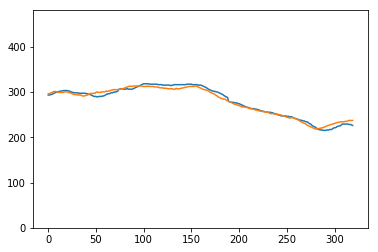

In [24]:
# visual data
id0 = random.randint(0, 9999)
id1 = random.randint(0, 4)
skyline_ = read_data_row("../data/train/{}.{}.txt".format(id0, id1), 1)
skyline = skyline_.strip().split(" ")
line0 = np.array(list(map(int, skyline[0].split(','))))
line1 = np.array(list(map(int, skyline[1].split(','))))
# line2 = Rotate()(line0)
plt.plot(line0)
plt.plot(line1)
# plt.plot(line2)
plt.ylim(0,480)

In [27]:
class Rotate(object):
    def __call__(self, line):
        angle = random.randint(-6,6)
        print(angle)
        pointx = len(line)//2
        pointy = line[pointx]
        angle = float(angle) * 3.1415  / float(180)
        x = np.arange(len(line))
        y = (x-pointx) * math.sin(angle) + (line - pointy) * math.cos(angle) + pointy
        
        return y
    
class Move(object):
    def __call__(self, line):
        delta = random.randint(-100,100)
        print(delta)
        return line + delta

-82
2


(0, 480)

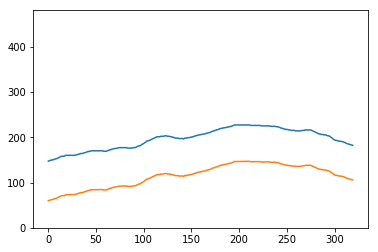

In [59]:
# show rotate and 
id0 = random.randint(0, 9999)
id1 = random.randint(0, 4)
skyline_ = read_data_row("../data/train/{}.{}.txt".format(id0, id1), 1)
skyline = skyline_.strip().split(" ")
line0 = np.array(list(map(int, skyline[0].split(','))))
line2 = Move()(line0)
line2 = Rotate()(line2)

plt.plot(line0)
plt.plot(line2)
plt.ylim(0,480)

# 差值统计

In [40]:
root_path = "../data/train/"
filenames = os.listdir(root_path)
point_x = []
point_y = []
for filename in tqdm(filenames):
    skyline_ = read_data_row(os.path.join(root_path, filename), 1)
    skyline = skyline_.strip().split(" ")
    err = sum(abs(np.array(list(map(int, skyline[0].split(',')))) - 
            np.array(list(map(int, skyline[1].split(','))))))
    point_x.append(err)
    point_y.append(np.array(list(map(int, skyline[2])))[0]*10+5)



100%|██████████| 100000/100000 [02:05<00:00, 795.26it/s]


<BarContainer object of 100000 artists>

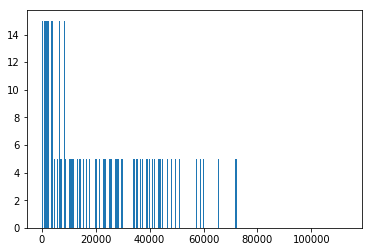

In [41]:
plt.bar(point_x[:100000], point_y[:100000])

(0, 100000)

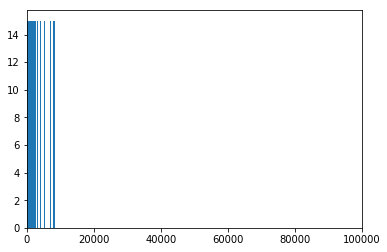

In [42]:
ptx = np.array(point_x[:100000])
pty = np.array(point_y[:100000])

plt.bar(ptx[pty==15], pty[pty==15])
plt.xlim(0, 100000)

(0, 15)

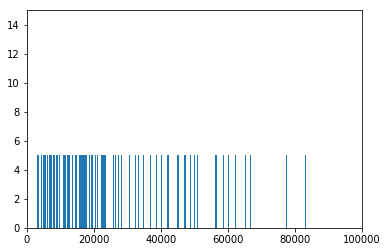

In [43]:
ptx = np.array(point_x[:100000])
pty = np.array(point_y[:100000])

plt.bar(ptx[pty==5], pty[pty==5])
plt.xlim(0, 100000)
plt.ylim(0, 15)

In [45]:
print(len([point_x[i] for i in range(len(point_x)) if  point_x[i] < 1000 and point_y[i]==5]))

0
